In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyarrow
!pip install pygam
!pip install shap

     |████████████████████████████████| 1.8MB 3.3MB/s 
     |████████████████████████████████| 235kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/3f/4a/331cf71b5043416aeba0df795e7c204c7ad277673f1938d11b
Successfully built shap


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from pygam import LogisticGAM
import xgboost as xgb

import shap  # package used to calculate Shap values

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe produced from `preprocess`.

In [119]:
train_df = pd.read_feather(f'{PATH_FEATURES}/agg_train-5')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/agg_test')

train_df.head()

,bookingID,acceleration_x_max,acceleration_x_min,acceleration_x_median,acceleration_x_std,acceleration_x_percentile,acceleration_y_max,acceleration_y_min,acceleration_y_median,acceleration_y_std,acceleration_y_percentile,acceleration_z_max,acceleration_z_min,acceleration_z_median,acceleration_z_std,acceleration_z_percentile,gyro_x_max,gyro_x_min,gyro_x_median,gyro_x_std,gyro_x_percentile,gyro_y_max,gyro_y_min,gyro_y_median,gyro_y_std,gyro_y_percentile,gyro_z_max,gyro_z_min,gyro_z_median,gyro_z_std,gyro_z_percentile,Speed_max,Speed_min,Speed_median,Speed_std,Speed_percentile,total_a_max,total_a_min,total_a_median,total_a_std,...,acceleration_y_sign_change,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,acceleration_x_count_above_2,acceleration_x_count_above_3,acceleration_y_count_above_2,acceleration_y_count_above_3,acceleration_z_count_above_2,acceleration_z_count_above_3,second_max,second_count,label
0,0,4.782614,-4.692294,-0.725250,0.928022,0.347582,-6.119916,-12.764703,-9.622127,0.639934,-8.936234,2.318857,-6.251807,-1.607663,1.141266,-0.210278,0.438371,-0.392537,0.002575,0.065954,0.083481,0.469724,-0.609930,-0.002239,0.100225,0.097003,0.372807,-0.731892,-0.003522,0.063685,0.061658,22.946083,-1.0,8.503366,7.199919,18.748623,12.988328,6.457339,9.852645,0.624159,...,0.0,5.173502,6.087766,9.125891,10.789780,128.0,0.525470,0.486405,0.972448,0.930134,491.0,0.629634,0.897888,1.315454,1.044398,452.0,0.568942,0.719506,0.698531,1.288449,486.0,0.601279,0.525920,0.929869,1.103402,0.0,0.565893,0.622762,0.912975,1.049871,251.0,77.0,17.0,1004.0,1004.0,309.0,101.0,1589.0,1004,0
1,1,3.813341,-5.352994,-0.563126,0.744157,0.059367,12.536156,6.623425,9.537963,0.533915,10.133488,1.481293,-5.355455,-2.175822,0.854271,-1.213190,0.126536,-0.125367,-0.001518,0.027740,0.029845,0.470837,-0.678183,-0.003491,0.091699,0.070302,0.235131,-0.121265,-0.000384,0.033838,0.040108,21.882141,-1.0,6.904588,7.059362,18.593060,12.790147,6.970526,9.844748,0.519956,...,0.0,4.126713,3.441799,7.568512,5.746438,20.0,0.173800,0.238639,0.403154,0.299289,454.0,0.352295,0.372715,0.388964,0.472042,361.0,0.231692,0.206280,0.340217,0.347914,409.0,0.347471,0.434247,0.486340,0.781718,0.0,0.308782,0.333688,0.397189,0.441969,104.0,32.0,7.0,851.0,851.0,546.0,115.0,1034.0,851,1
2,2,1.956122,-2.971295,0.433364,0.756589,1.145421,13.333716,7.941810,9.814133,0.505693,10.212540,2.312870,-3.282551,0.366324,1.020021,1.235446,0.282162,-0.155218,0.001164,0.053903,0.052843,0.431695,-0.462000,0.001035,0.117321,0.092787,0.255884,-0.125907,0.001764,0.036215,0.032063,9.360483,0.0,2.998761,2.897762,7.260158,13.403410,8.234988,9.877755,0.515173,...,0.0,4.683201,2.942564,5.363175,5.947378,61.0,0.396452,0.300546,0.665232,0.558331,90.0,0.347582,0.301157,0.391565,0.490525,49.0,0.332922,0.290161,0.623083,0.437990,96.0,0.295072,0.479682,0.647632,0.497192,0.0,0.224242,0.336153,0.424833,0.534245,37.0,1.0,0.0,195.0,195.0,9.0,2.0,825.0,195,1
3,4,2.019635,-2.866458,-0.381168,0.527220,0.183690,-7.064984,-18.847833,-9.364999,0.598023,-8.921670,0.296381,-9.374869,-2.608658,0.779529,-1.627701,0.438732,-0.420507,-0.022799,0.042342,0.011330,0.652628,-0.506531,0.024504,0.112567,0.136198,0.505220,-0.348189,-0.001147,0.065927,0.064638,19.780001,0.0,3.310000,5.595901,16.135000,21.053265,7.703982,9.791035,0.620066,...,0.0,7.400095,6.435437,8.689844,13.835532,4.0,0.434474,0.484957,0.894047,0.838916,248.0,0.702851,0.701457,1.298823,1.169583,354.0,0.509004,0.616145,1.086375,0.714633,488.0,0.246631,0.297355,0.461395,0.405312,0.0,0.251567,0.361889,0.568666,0.403067,168.0,12.0,0.0,1094.0,1094.0,908.0,298.0

## Feature selection
For the first run, select all 164 features but after running `lightgbm` twice and narrowing the important features into half each run, we are left with 41 features. The 41 features here manage to achieve a higher AUC-ROC score compared to 164 features.

In [0]:
run_model = False

In [160]:
exclude = ['label', 'bookingID', 'second_max', 'second_max']

# if we have not run the model to 
# narrow down the features,
# start with 164 features
if not run_model:
    features = [c for c in train_df.columns if c not in exclude]
    
else:
    # features = features_df['features'].tolist()
  
    # agg-5
    features = ['horsepower_median', 'Speed_max', 'Speed_median', 
                'roll_std', 'pitch_count_above_mean', 'horsepower_min', 
                'gyro_y_fo_max', 'total_gyro_min', 'Speed_percentile', 
                'acceleration_z_percentile', 'gyro_y_min', 
                'acceleration_z_kurtosis', 'roll_absolute_sum_of_changes', 
                'acceleration_y_mean_abs_change', 'gyro_z_kurtosis', 
                'roll_gyro_std', 'xz_percentile', 
                'acceleration_x_mean_abs_change', 'gyro_z_median',
                'gyro_y_so_min', 'gyro_y_max', 'gyro_y_kurtosis', 
                'horsepower_percentile', 'total_a_std', 'roll_kurtosis', 
                'acceleration_y_kurtosis', 'pitch_gyro_std', 
                'pitch_gyro_median', 'acceleration_z_std', 'xz_max', 
                'pitch_kurtosis', 'total_a_median', 'roll_so_max', 
                'roll_gyro_median', 'roll_gyro_min', 'pitch_min', 
                'gyro_y_count_above_mean', 'gyro_x_percentile', 
                'acceleration_z_count_above_3', 'acceleration_x_min', 'xy_std']
    

len(features)    

41

## Model 1
### Lightgbm
First, run `lightgbm` and perform feature selection by retaining the top half important features for each run.

In [0]:
# ==================
# set random seed and
# use StratifiedKFold 
# for validation
# ==================
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

In [0]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

# # UNCOMMENT
# oof_test = np.zeros((len(test_df), ))
# oof_test_skf = np.empty((folds, len(test_df),))

In [0]:
# ==================
# lgb params
# ==================
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'lambda_l1': 5,
    'lambda_l2': 5,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

In [164]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid, 
                              num_iteration=lgb_clf.best_iteration)
    
    # # UNCOMMENT
    # oof_test_skf[fold, :] = lgb_clf.predict(test_df[features],
    #                                         num_iteration=lgb_clf.best_iteration)
    

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
# # UNCOMMENT    
# oof_test[:] = oof_test_skf.mean(axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.808793	valid_1's auc: 0.69253
[200]	training's auc: 0.870116	valid_1's auc: 0.69385
Early stopping, best iteration is:
[178]	training's auc: 0.857974	valid_1's auc: 0.695447
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.807351	valid_1's auc: 0.704683
Early stopping, best iteration is:
[56]	training's auc: 0.773076	valid_1's auc: 0.710438
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.808892	valid_1's auc: 0.713983
Early stopping, best iteration is:
[86]	training's auc: 0.797653	valid_1's auc: 0.714913
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.810746	valid_1's auc: 0.680656
[200]	training's auc: 0.870094	valid_1's auc: 0.683367
Early stopping, best iteration is:
[127]	training's auc: 0.82875	valid_1's auc: 0.683967
Training until validation scores don't improve for 100 rounds.


In [150]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.698501294, std: 0.012232398. All auc: 0.697670000.


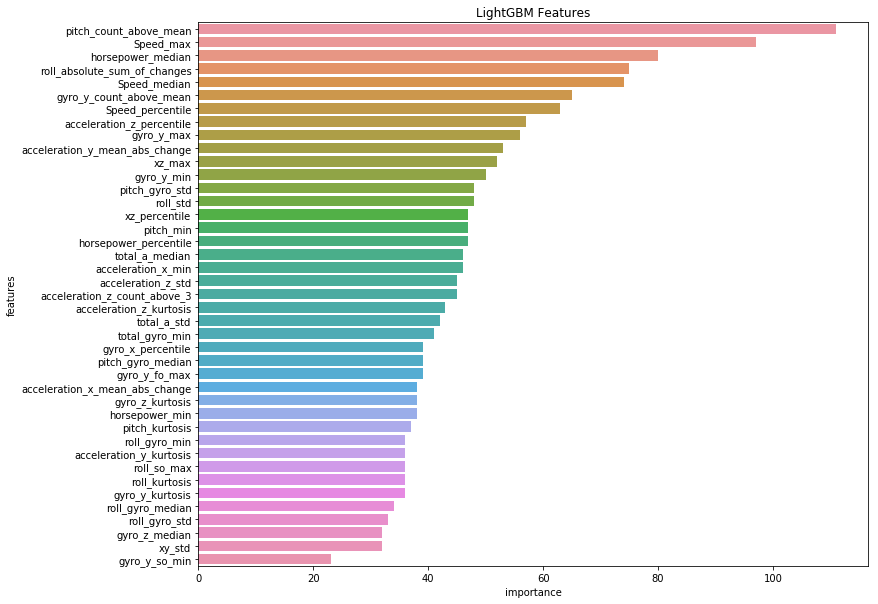

In [165]:
# ran model, set flag to true
run_model = True

feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

# only plot feature importance 
# for final run
if len(features_df) < 42:
    plt.figure(figsize=(12,10))
    sns.barplot(x="importance", y="features", 
                data=features_df)
    plt.title('LightGBM Features')
    plt.show()

# retain top half important features
if (len(features) > 20):
    features_df = features_df[:int(len(features)/2)]

## Observations
Before excluding `max_second`, it happens to be the most predictive variable to whether is a trip safe or dangerous. This "feature" should be considered as "noise" since its main function is to record each trip session in order. Removing this "feature" reduces the ROC-AUC from 0.730 to 0.6919. This led me to suspect that Grab has taken more readings for each trip confirm whether is a trip dangerous.

For the sake of running the final model and submitting the final prediction, I also removed `count_second`, the number of sessions recorded for each `bookingID` since this should also be regarded as noise.



## Submission

In [0]:
# # UNCOMMENT
# submit predictions
# oof_test.to_csv(f'{PATH_FEATURES}/submission.csv')

## Model 2
### Generalized Additive Model
Run `pygam`. Start by selecting smoothing parameters `lam` by doing a `random grid search`.

In [0]:
# ==================
# scale the features
# ==================
s = StandardScaler()

X = s.fit_transform(train_df[features].values)
y = train_df['label'].values

In [0]:
# ==================
# random search for  
# smoothing parameters (lambda)
# code from pygam's documentation
# ==================
np.random.seed(0)
lams = np.random.rand(5, 41) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) 

In [171]:
# ==================
# fit the model
# ==================
%%time
gam = LogisticGAM().gridsearch(X, y, 
                               lam=lams,
                               keep_best=True)

100% (5 of 5) |##########################| Elapsed Time: 0:05:29 Time:  0:05:29


CPU times: user 9min 36s, sys: 42.3 s, total: 10min 18s
Wall time: 5min 29s


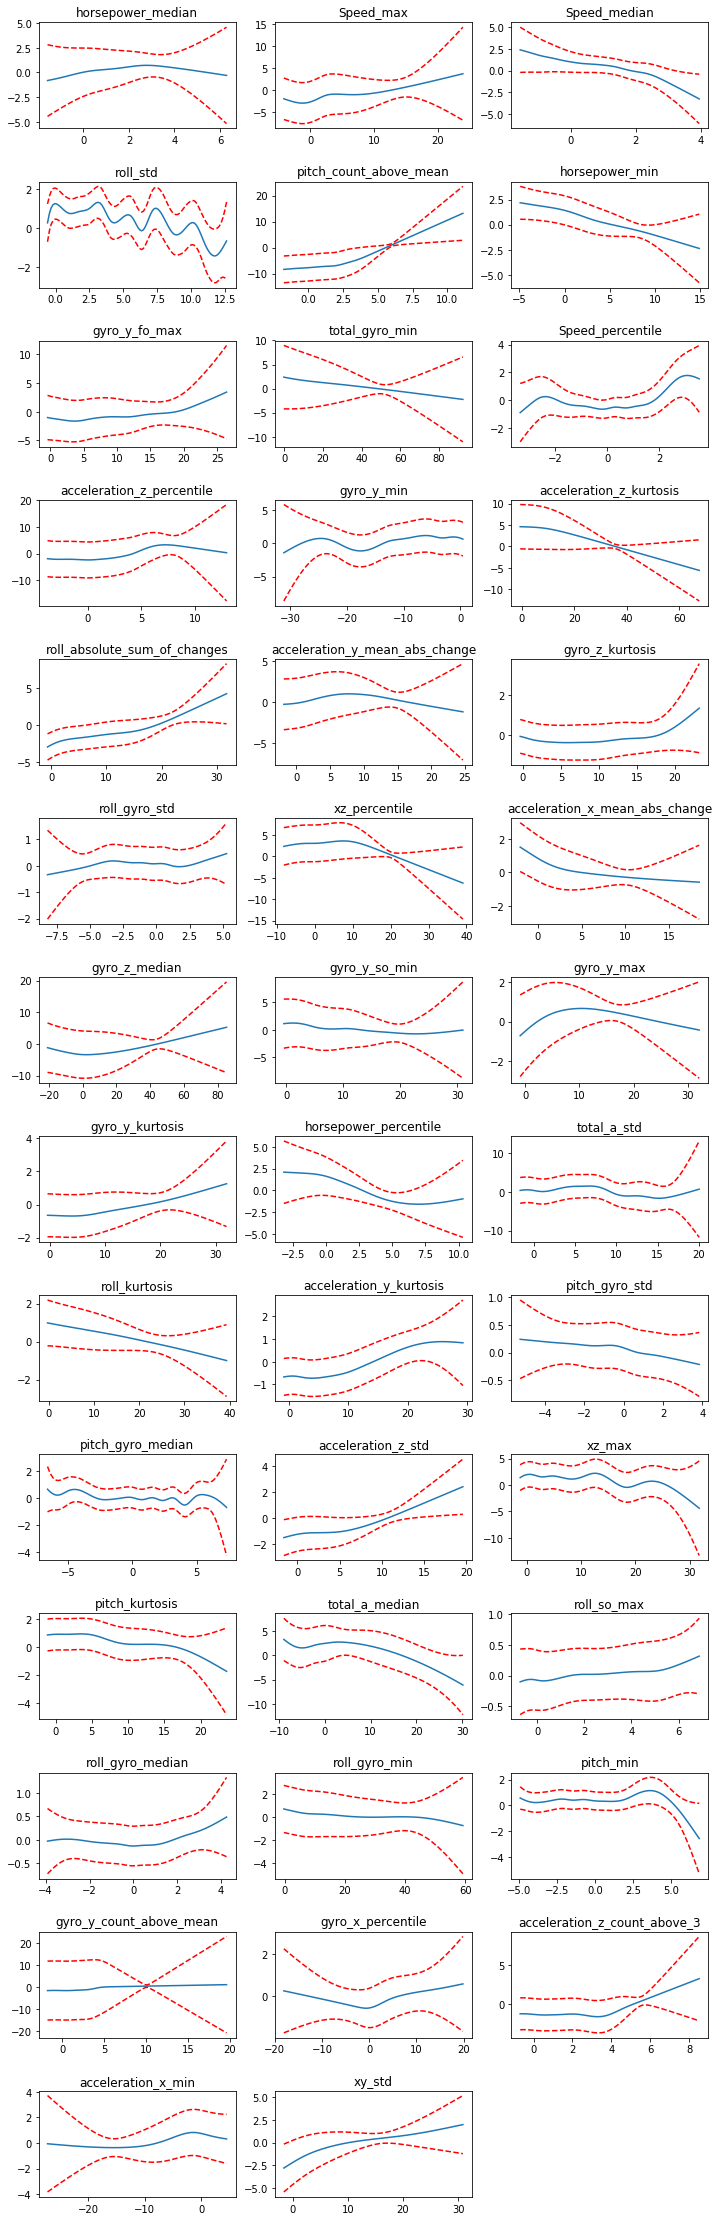

In [172]:
# ==================
# partial dependence plot
# on all features
# ==================
plt.figure(figsize=(12,40))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    plt.subplot(14, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')    
    plt.title(features[i])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

In [173]:
# ==================
# check for accuracy
# ==================
gam.accuracy(X, y)

0.7804

In [174]:
# ==================
# logistic GAM statistic summary
# ==================
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    210.4535
Link Function:                        LogitLink Log Likelihood:                                  -9785.709
Number of Samples:                        20000 AIC:                                             19992.325
                                                AICc:                                           19996.8656
                                                UBRE:                                                3.008
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.13
Feature Function                  Lam

In [0]:
# ==================
# using the best lambdas
# found, perform KFold
# ==================
random_state = 42
np.random.seed(random_state)

folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [176]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM(lam=gam.lam).fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)
    
    # ==================
    # impute NaN with 0
    # ==================
    nans = np.where(np.isnan(p_valid))
    
    for i in nans:
        p_valid[i] = 0

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s auc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

OptimizationError: ignored

In [0]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

## Model 3
### XGBoost

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# ==================
# xgb params
# ==================
xgb_params = {
    'objective':'binary:logistic',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'max_depth': 5,
    "seed": random_state
}

In [180]:
len(features)

41

In [181]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

[0]	train-error:0.220201	valid-error:0.233442
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.205013	valid-error:0.228943
Stopping. Best iteration:
[44]	train-error:0.212513	valid-error:0.227193

[0]	train-error:0.222438	valid-error:0.225
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.206687	valid-error:0.21625
Stopping. Best iteration:
[52]	train-error:0.21475	valid-error:0.21425

[0]	train-error:0.220812	valid-error:0.2265
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.206188	valid-error:0.22225
Stopping. Best iteration:
[53]	train-error:0.211625	valid-error:0.22175

[0]	train-error:0.22175	valid-error:0.2275
Multiple eval metri

In [182]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.692475698, std: 0.011069066. All auc: 0.690603889.


## Interpretation
Understanding each feature from the best  model, `lightgbm` using `shap`.

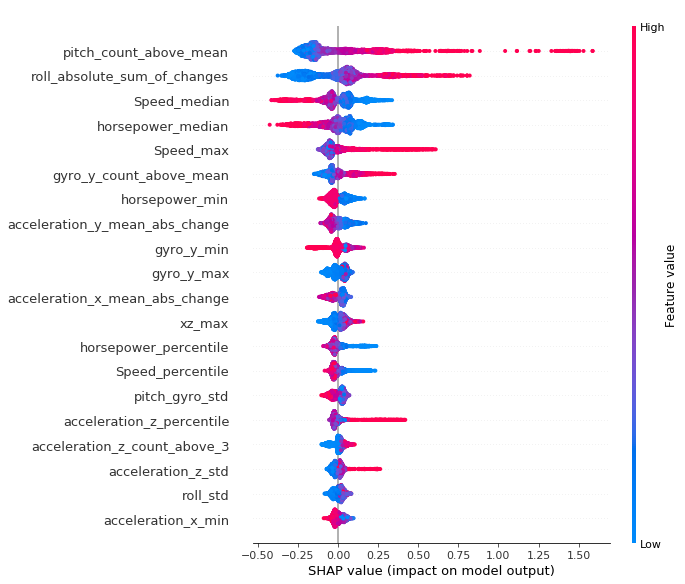

In [183]:
shap_values = shap.TreeExplainer(lgb_clf).shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)

Draw partial depedence plot for all remaining features.

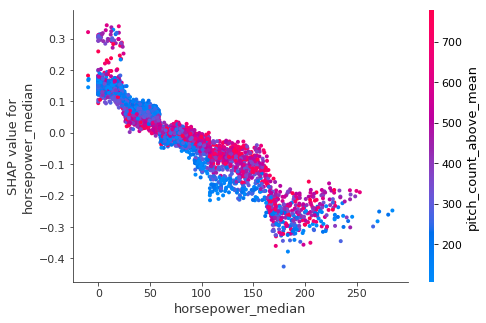

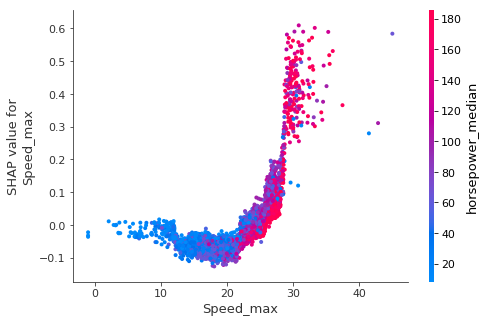

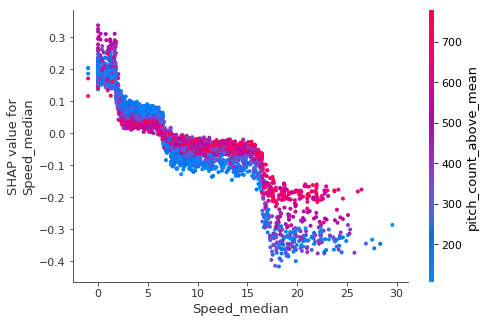

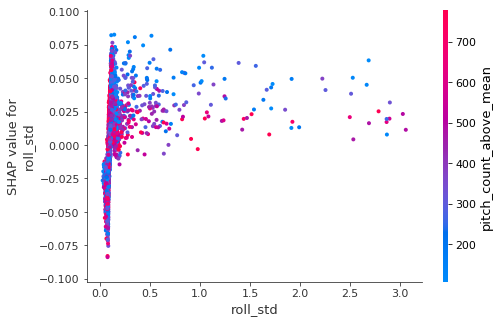

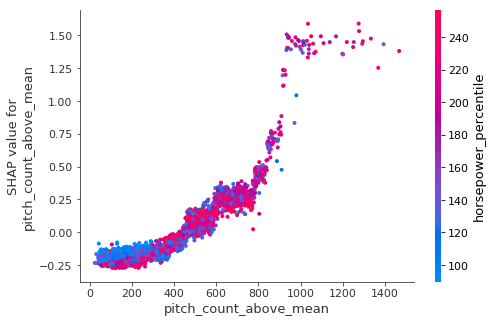

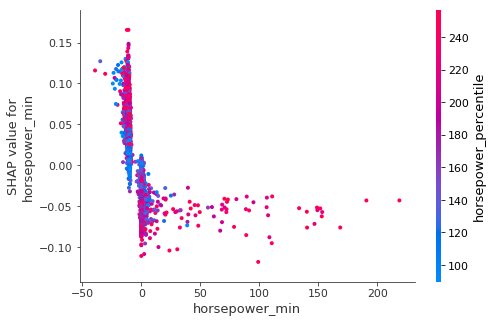

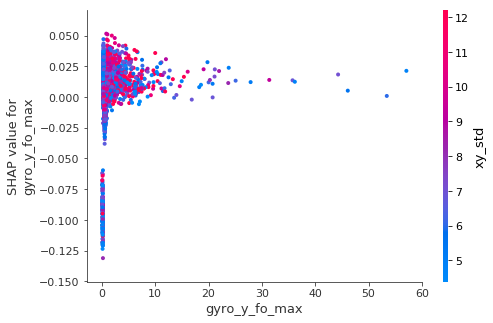

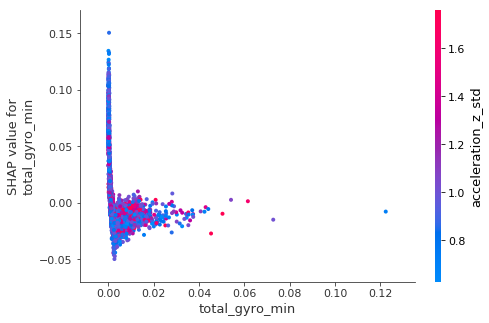

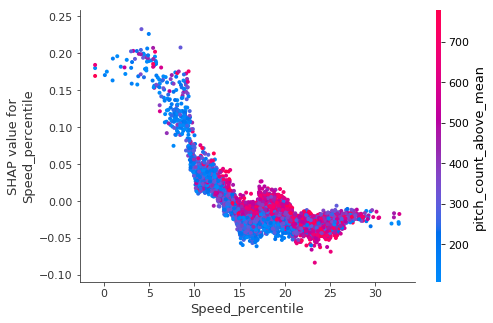

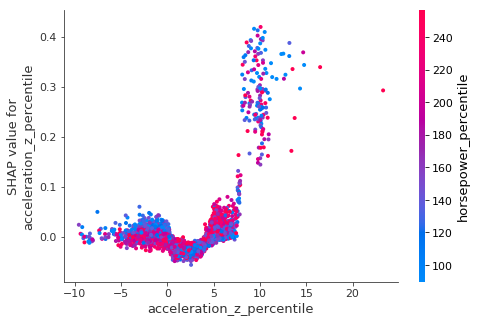

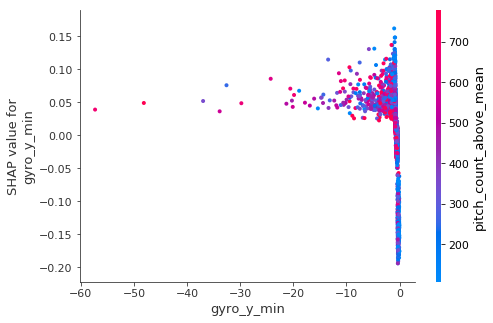

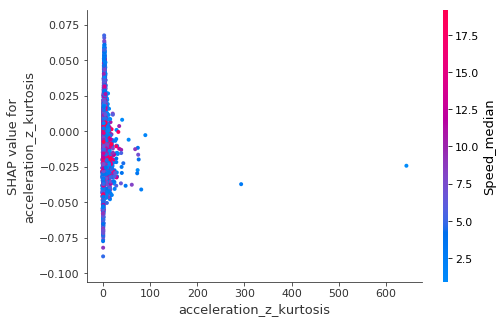

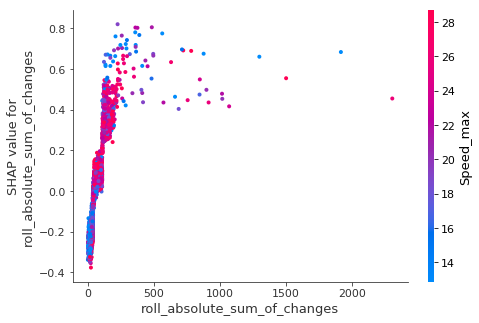

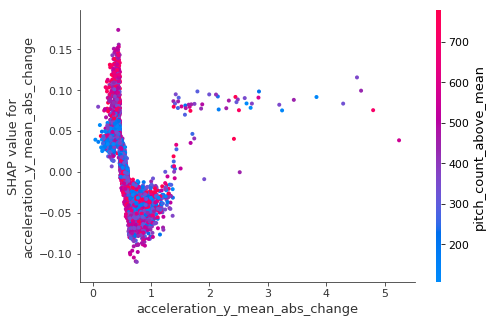

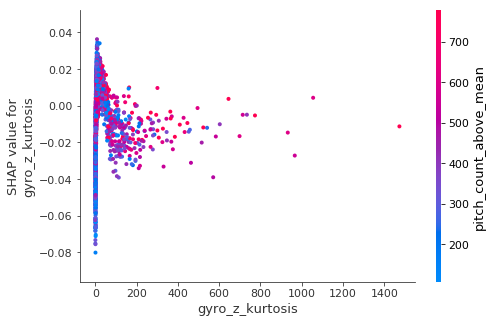

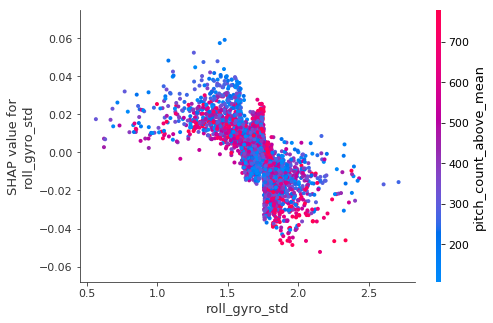

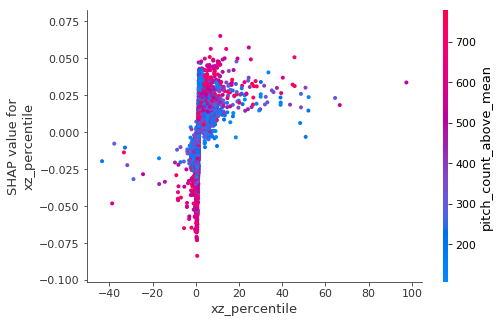

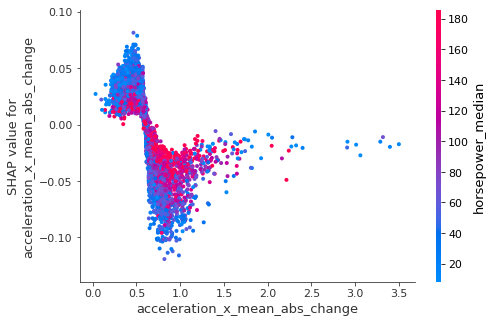

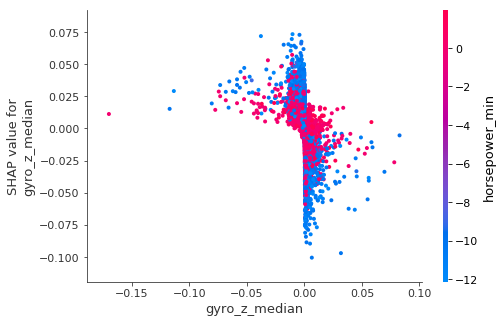

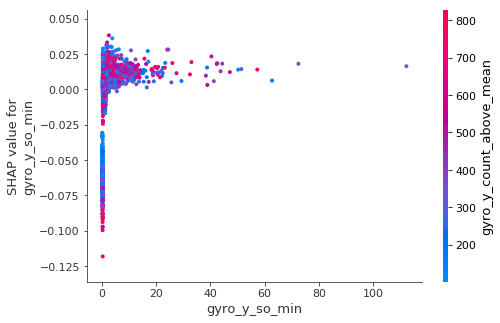

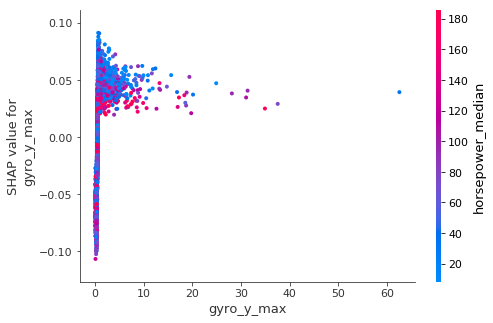

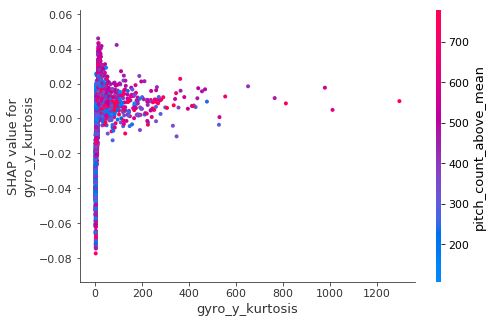

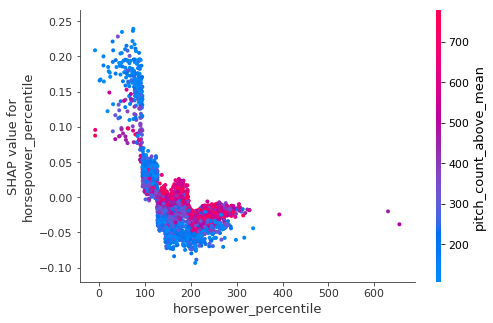

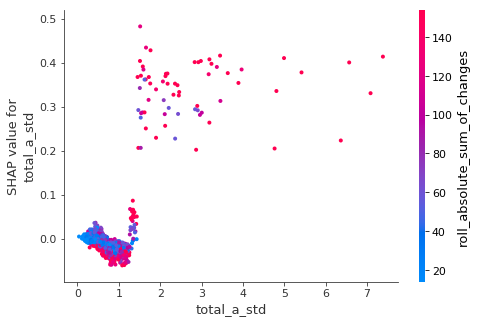

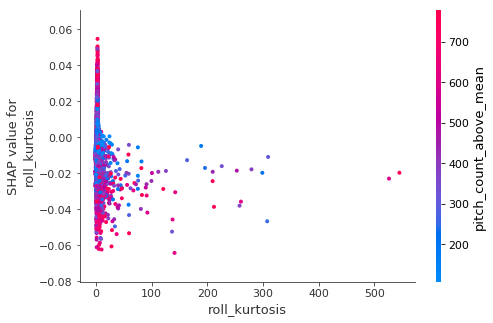

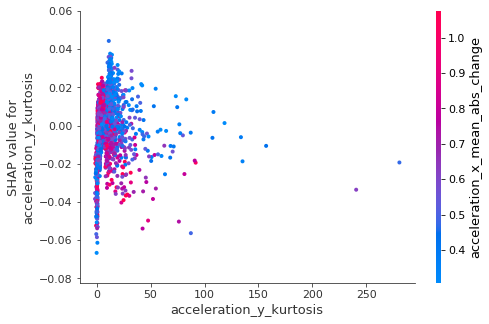

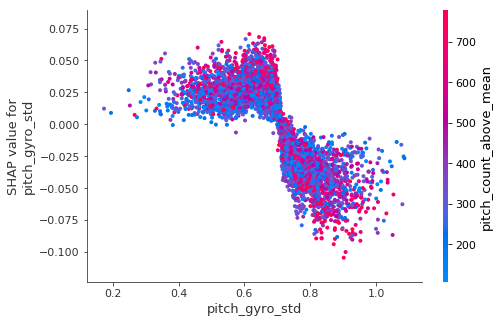

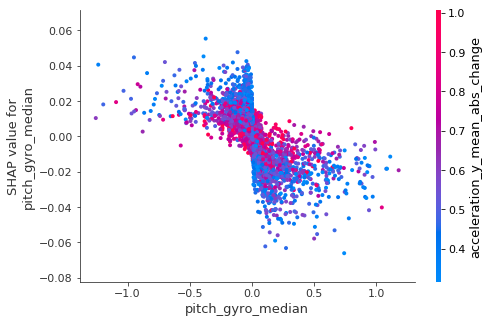

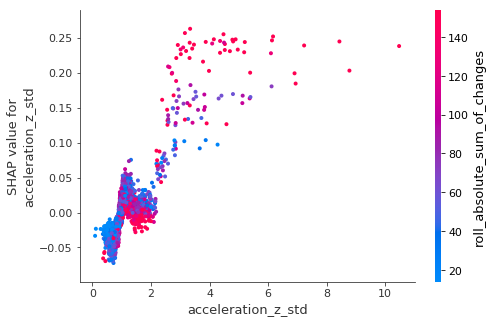

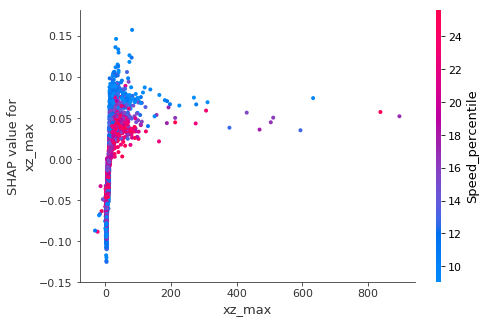

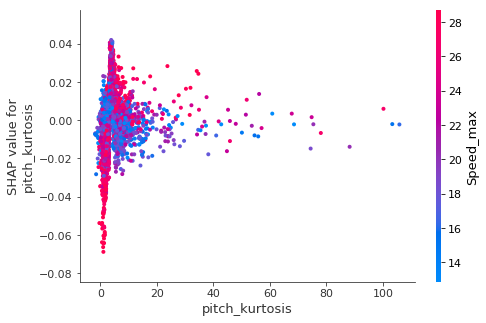

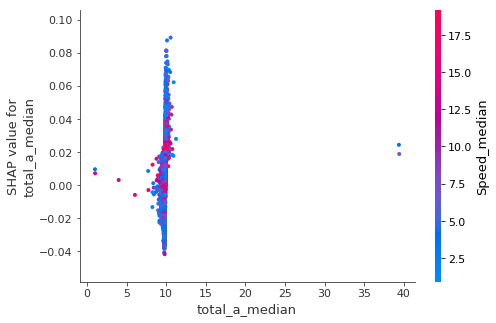

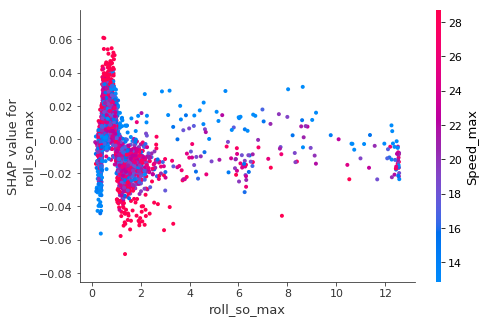

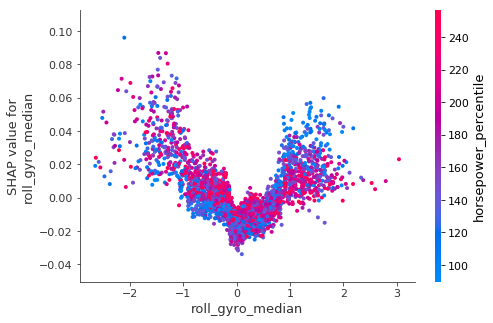

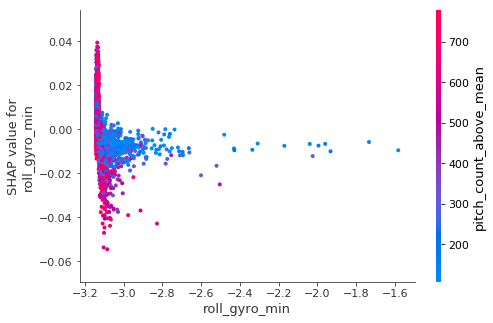

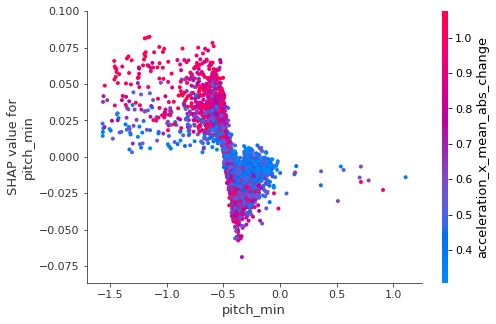

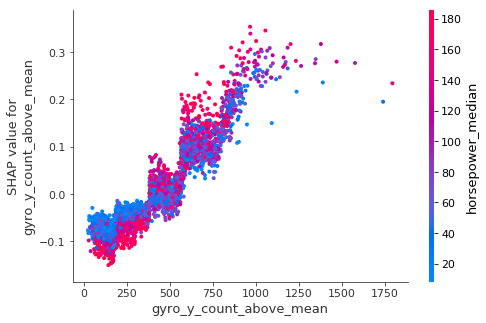

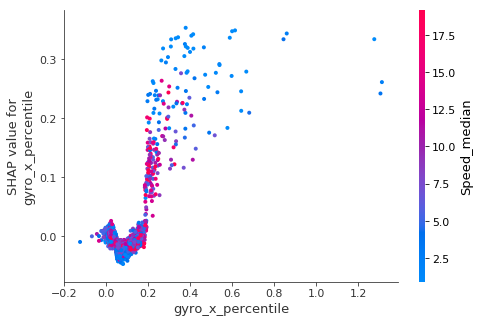

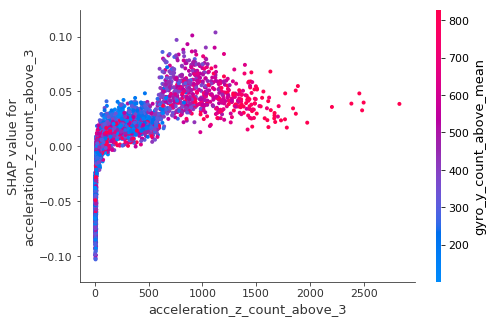

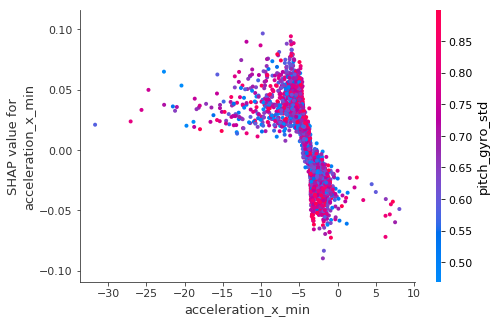

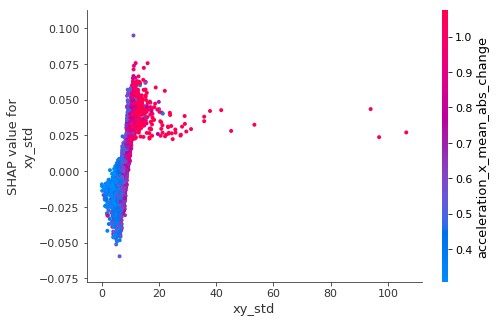

In [184]:
for f in features:
    shap.dependence_plot(f, shap_values, X_valid)

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


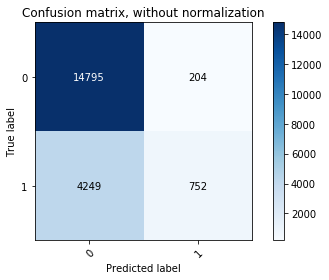

In [186]:
predict_bin = (oof['predict'] > 0.5).astype(int)

# Plot non-normalized confusion matrix
plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
#                       normalize=True,
#                       title='Confusion matrix, with normalization')

plt.show()

## What did not work
### Local Outlier Factor

Hypothesis: Outliers in certain readings are most important to predicting whether is a trip dangerous. With that in mind, I tried applying the `LocalOutlierFactor` algorithm from `sklearn` but was not successful.

### Logistic Regression
AUC-ROC was around 0.57.